In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/


# **Import Libraries**

In [2]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [3]:
from keras.layers import Dense
from keras.models import Model
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [4]:
from tensorflow.keras.optimizers import Adam

# **Preprocessing**

In [5]:
df=pd.read_csv('/content/drive/MyDrive/crowd counting/labels.csv')

In [6]:
df['image_id']=df['id'].map('seq_{:06d}.jpg'.format)

In [7]:
def image_data_gen(size, batch_size,dir,df,x_col,y_col):
  data_gen=ImageDataGenerator(rescale=1.0/255,validation_split=0.3,zca_whitening=False,horizontal_flip=False,vertical_flip=False,samplewise_std_normalization=False,preprocessing_function=preprocess_input)
  flow_params=dict(dataframe=df,
    directory=dir,
    x_col=x_col,
    y_col=y_col,
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0)
  train_gen=data_gen.flow_from_dataframe(
    subset='training',
    **flow_params
    )
  valid_gen=data_gen.flow_from_dataframe(
      subset='validation',
    **flow_params)
  return train_gen,valid_gen

In [8]:
size=224
batch_size=50
dir='/content/drive/MyDrive/crowd counting/frames/frames/'
train_gen,valid_gen=image_data_gen(size,batch_size,dir,df,'image_id','count')

Found 1400 validated image filenames.
Found 600 validated image filenames.


# **Plot Images**

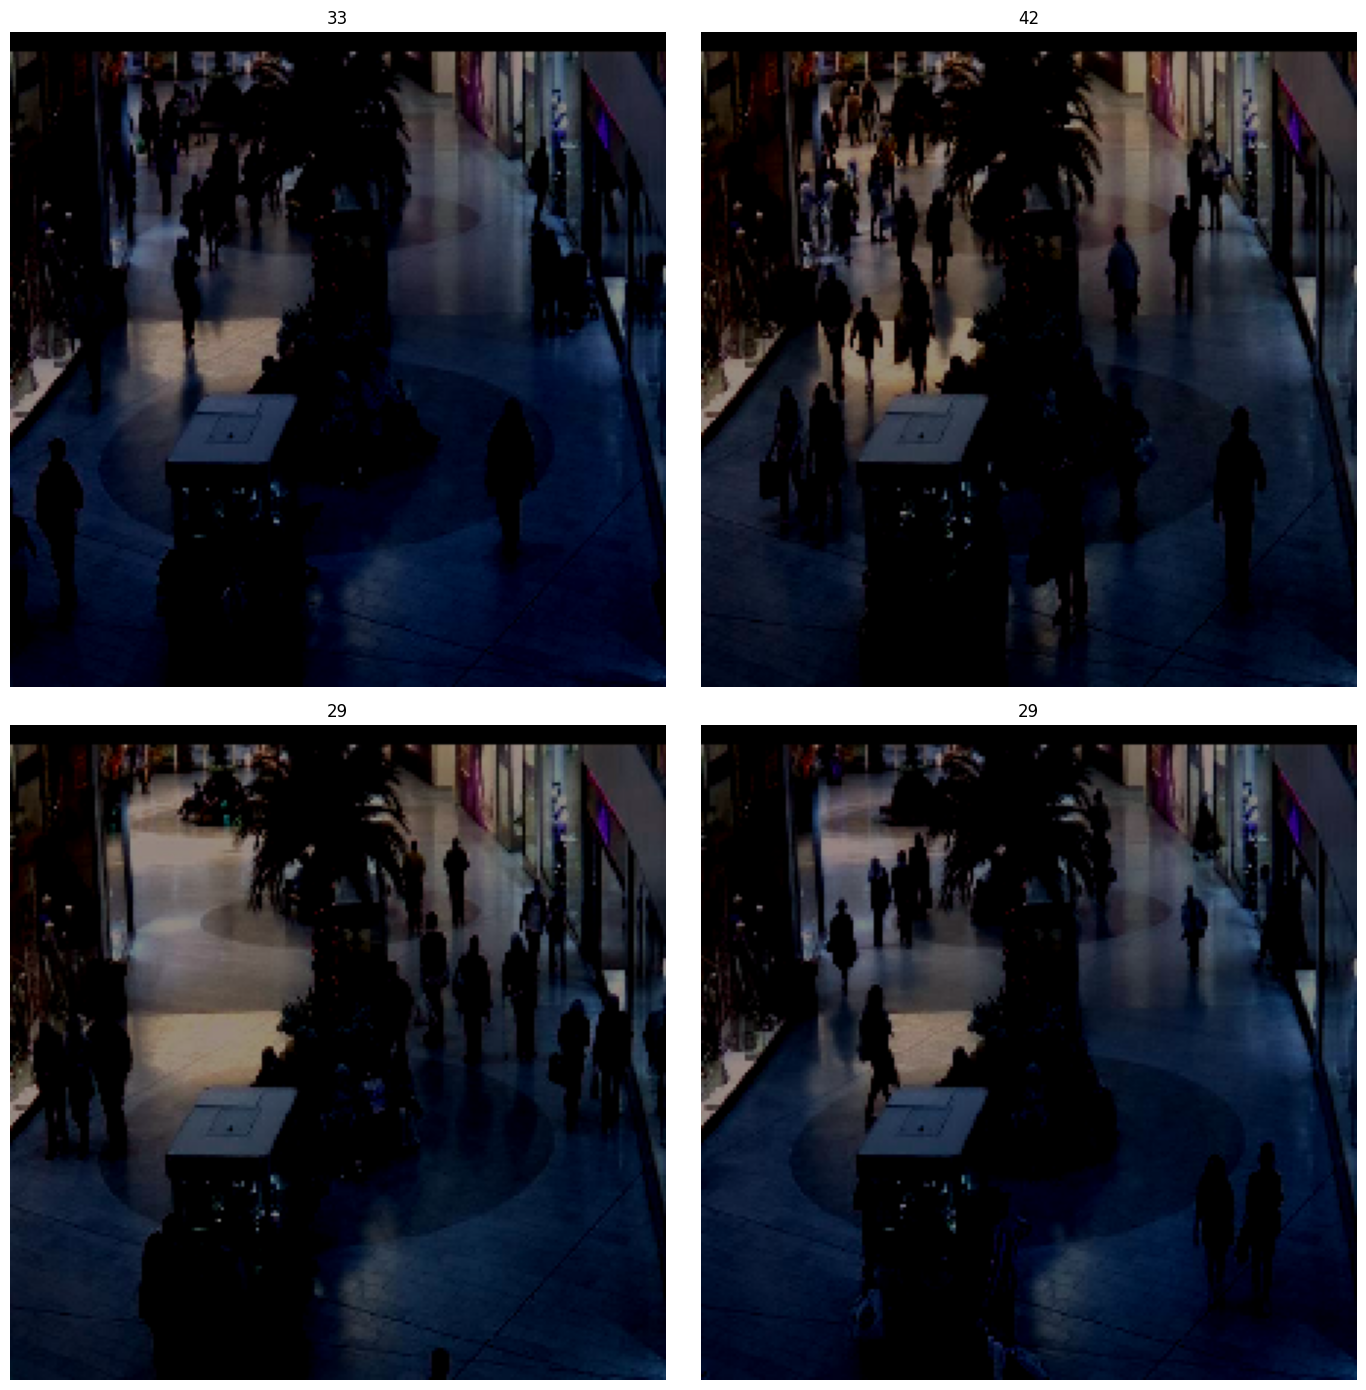

In [9]:
batch = next(train_gen)
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

# **Define Model**

In [10]:
def define_model(size):
  base=ResNet50(
      weights='imagenet',
      include_top=False,
      input_shape=(size, size, 3),
      pooling='avg'
  )
  x=base.output
  x_in=Dense(1024,activation='relu')(x)
  out=Dense(1,activation='linear')(x_in)
  model=Model(inputs=base.input, outputs=out)
  return model

In [11]:
model=define_model(size)

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# **Training and Testing**

In [13]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.000001
)
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="mean_squared_error",
    metrics=['mean_absolute_error', 'mean_squared_error']
)
model.fit(train_gen,validation_data=valid_gen, epochs=30, verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/30
28/28 [==============================] - 543s 18s/step - loss: 1099.1761 - mean_absolute_error: 17.0204 - mean_squared_error: 1099.1761 - val_loss: 321110001817133115200622053818368.0000 - val_mean_absolute_error: 17919542009266176.0000 - val_mean_squared_error: 321110001817133115200622053818368.0000 - lr: 0.0100
Epoch 2/30
28/28 [==============================] - 18s 622ms/step - loss: 36.8601 - mean_absolute_error: 4.8915 - mean_squared_error: 36.8601 - val_loss: 14527895516315910144.0000 - val_mean_absolute_error: 3811547648.0000 - val_mean_squared_error: 14527895516315910144.0000 - lr: 0.0100
Epoch 3/30
28/28 [==============================] - 18s 636ms/step - loss: 30.7331 - mean_absolute_error: 4.4573 - mean_squared_error: 30.7331 - val_loss: 2161083023360.0000 - val_mean_absolute_error: 1470061.7500 - val_mean_squared_error: 2161083023360.0000 - lr: 0.0100
Epoch 4/30
28/28 [==============================] - 18s 634ms/step - loss: 23.7403 - mean_absolute_error: 3.8855 

In [20]:
valid_gen.reset()
true_labels=[]
preds=[]
for i in range(len(valid_gen)):
  l=next(valid_gen)
  true_label=l[1]
  pred=model.predict(l[0])[:,0]
  true_labels.append(true_label)
  preds.append(pred)


2/2 [==============================] - 0s 80ms/step
